<a href="https://colab.research.google.com/github/AFAgarap/clustering_vae/blob/master/notebooks/fashionmnist_vae_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

k-Means Clustering on Reconstructed Latent Data Representation from Variational Autoencoder
====

## Overview

We use a variational autoencoder to learn the latent representation of data and to reconstruct the original data. Then, we use k-Means clustering on the original data representation, reconstructed data representation, and latent data representation.

## Setup

Install TensorFlow 2.0


In [ ]:
!pip install --quiet tensorflow-gpu==2.0.0-alpha

    100% |████████████████████████████████| 332.1MB 77kB/s 
    100% |████████████████████████████████| 419kB 12.9MB/s 
    100% |████████████████████████████████| 3.0MB 9.3MB/s 
    100% |████████████████████████████████| 61kB 28.7MB/s 


Load TensorBoard for visualization.

In [ ]:
%load_ext tensorboard.notebook
%tensorboard --logdir ./tmp

## Variational Autoencoder

In this notebook, we will write a variational autoencoder model using the TensorFlow subclassing API. We are going to use the Fashion-MNIST dataset (Grayscale images of fashion articles).

### Setup

Let's start by importing the libraries and functions that we will need.

In [27]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tensorflow as tf
from time import time
from warnings import simplefilter

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

Let's set random seeds for reproducibility of results, and suppression of warning messages.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
simplefilter(action='ignore', category=FutureWarning)

### Dataset

We'll use the Fashion-MNIST dataset.

In [4]:
(training_features, training_labels), (test_features, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Scaling it for numerical computation stability.

In [5]:
training_features = training_features.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
training_features += tf.random.normal(shape=training_features.shape, stddev=5e-2)
test_features = test_features.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

Display the noise-augmented training dataset. This is done to avoid overfitting.

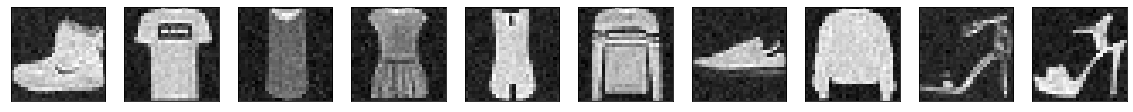

In [6]:
plt.figure(figsize=(20, 4))
for index in range(10):
    ax = plt.subplot(2, 10, index + 1)
    plt.imshow(training_features[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Create a `tf.data.Dataset` for the training dataset for asynchronous process of training mini-batches.

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_features)
train_dataset = train_dataset.prefetch(2048).shuffle(buffer_size=1024).batch(512, drop_remainder=True)

W0630 16:15:46.318249 140291555682112 deprecation.py:323] From /home/darth/tf2/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Feed-Forward VAE
### Define Reparameterization

We use reparameterization trick to sample from a distribution with the learned mean $\mu$ and learned variance $\sigma^{2}$.

$$ z = \mu + \exp\bigg(\frac{\sigma^{2}}{2}\bigg) * \epsilon \sim \mathcal{N}\big(0, 1\big)$$

This is called by the `Encoder` layer.

In [8]:
class Sampling(tf.keras.layers.Layer):
    def call(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim), mean=0., stddev=1.)
        return z_mean + epsilon * tf.exp(0.5 * z_log_var)

### Define an encoder layer

The first component, the encoder, is similar to a conventional feed-forward network.

In [9]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(28, 28, 1))
        self.reshape = tf.keras.layers.Reshape(target_shape=(784, ))
        self.hidden_layer_1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
#         self.hidden_layer_2 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)
#         self.hidden_layer_3 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)
        self.z_mean_layer = tf.keras.layers.Dense(units=latent_dim)
        self.z_log_var_layer = tf.keras.layers.Dense(units=latent_dim)
        self.sampling = Sampling()

    def call(self, input_features):
        input_features = self.input_layer(input_features)
        input_features = self.reshape(input_features)
        activation_1 = self.hidden_layer_1(input_features)
#         activation_2 = self.hidden_layer_2(activation_1)
#         activation_3 = self.hidden_layer_3(activation_2)
        z_mean = self.z_mean_layer(activation_1)
        z_log_var = self.z_log_var_layer(activation_1)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

### Define a decoder layer

The second component, the decoder, is also similar to a feed-forward network. 

In [10]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
#         self.hidden_layer_1 = tf.keras.layers.Dense(units=32, activation=tf.nn.relu)
#         self.hidden_layer_2 = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)
        self.hidden_layer_3 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.sigmoid)

    def call(self, input_features):
#         activation_1 = self.hidden_layer_1(input_features)
#         activation_2 = self.hidden_layer_2(activation_1)
        activation_3 = self.hidden_layer_3(input_features)
        output = self.output_layer(activation_3)
        return output

### Build the variational autoencoder model

We can now build the variational autoencoder model by instantiating `Encoder` and `Decoder` layers.

In [11]:
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim, original_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(original_dim=original_dim)

    def call(self, input_features):
        z_mean, z_log_var, latent_code = self.encoder(input_features)
        reconstructed = self.decoder(latent_code)
        kl_divergence = -5e-2 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1 - z_log_var)
        self.add_loss(kl_divergence)
        return reconstructed

### Train the model

Now all we have to do is instantiate the VAE model and choose an optimization function, then pass the intermediate dimension and the original dimension of the images.

In [12]:
original_dim = 784
vae = VariationalAutoencoder(latent_dim=10, original_dim=784)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
mse_loss_fn = tf.keras.losses.BinaryCrossentropy()
loss_metric = tf.keras.metrics.Mean()

### The training loop

Finally, we will write a function to run the training loop. This function will take arguments for the model, the optimization function, the loss, the dataset, and the training epochs.

The training loop itself uses a `GradientTape` context defined in train for each batch.

In [13]:
epochs = 500
writer = tf.summary.create_file_writer('tmp/fashion-mnist')

with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(epochs):
            for step, batch_features in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    z_mean, z_log_var, z = vae.encoder(tf.constant(batch_features))
                    reconstructed = vae.decoder(z)
                    loss = mse_loss_fn(batch_features.numpy().reshape(-1, 784), reconstructed)
                    loss += sum(vae.losses)

                grads = tape.gradient(loss, vae.trainable_variables)
                optimizer.apply_gradients(zip(grads, vae.trainable_variables))

                loss_metric(loss)
            
            if (epoch != 0) and ((epoch + 1) % 50 == 0):
                print('Epoch {}/{} : mean loss = {}'.format(epoch + 1, epochs, loss_metric.result()))
            tf.summary.scalar('loss', loss_metric.result(), step=step)
            tf.summary.image('original', batch_features, max_outputs=10, step=step)
            tf.summary.image('reconstructed', reconstructed.numpy().reshape(-1, 28, 28, 1), max_outputs=10, step=step)

Epoch 50/500 : mean loss = 0.30065393447875977
Epoch 100/500 : mean loss = 0.2926449477672577
Epoch 150/500 : mean loss = 0.28925371170043945
Epoch 200/500 : mean loss = 0.2872825264930725
Epoch 250/500 : mean loss = 0.28596705198287964
Epoch 300/500 : mean loss = 0.28501632809638977
Epoch 350/500 : mean loss = 0.28429338335990906
Epoch 400/500 : mean loss = 0.2837197482585907
Epoch 450/500 : mean loss = 0.2832474410533905
Epoch 500/500 : mean loss = 0.28285354375839233


## Export Model

In [14]:
vae.save_weights('export/fmnist/1', 'tf')

## Visualization

In [15]:
def plot_code(latent_code):
    plt.figure(figsize=(20, 4))
    for index in range(10):
        ax = plt.subplot(2, 10, index + 1)
        plt.imshow(latent_code[index].reshape(4, 4), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [16]:
noisy_test_features = test_features + tf.random.normal(shape=test_features.shape, stddev=5e-2)

In [23]:
_, _, z = vae.encoder(tf.constant(noisy_test_features))
reconstructed_scatter = vae.decoder(z)
reconstructed_scatter = reconstructed_scatter.numpy().reshape(-1, 784)

pca = PCA(n_components=10)
reduced_training_features = pca.fit_transform(training_features.numpy().reshape(-1, 784))
reduced_test_features = pca.transform(noisy_test_features.numpy().reshape(-1, 784))

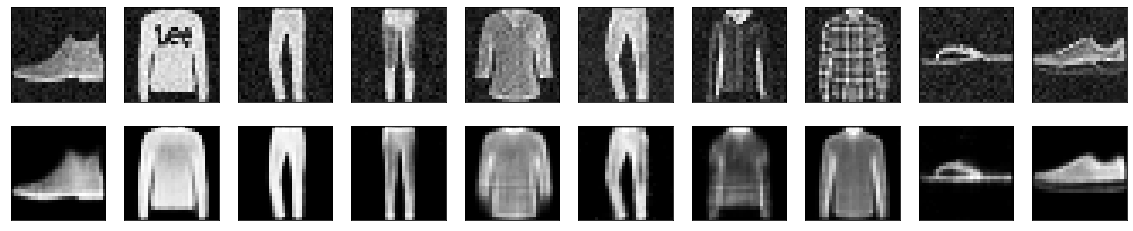

In [24]:
plt.figure(figsize=(20, 4))
for index in range(10):
    ax = plt.subplot(2, 10, index + 1)
    plt.imshow(noisy_test_features[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    ax = plt.subplot(2, 10, index + 1 + 10)
    plt.imshow(reconstructed_scatter[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

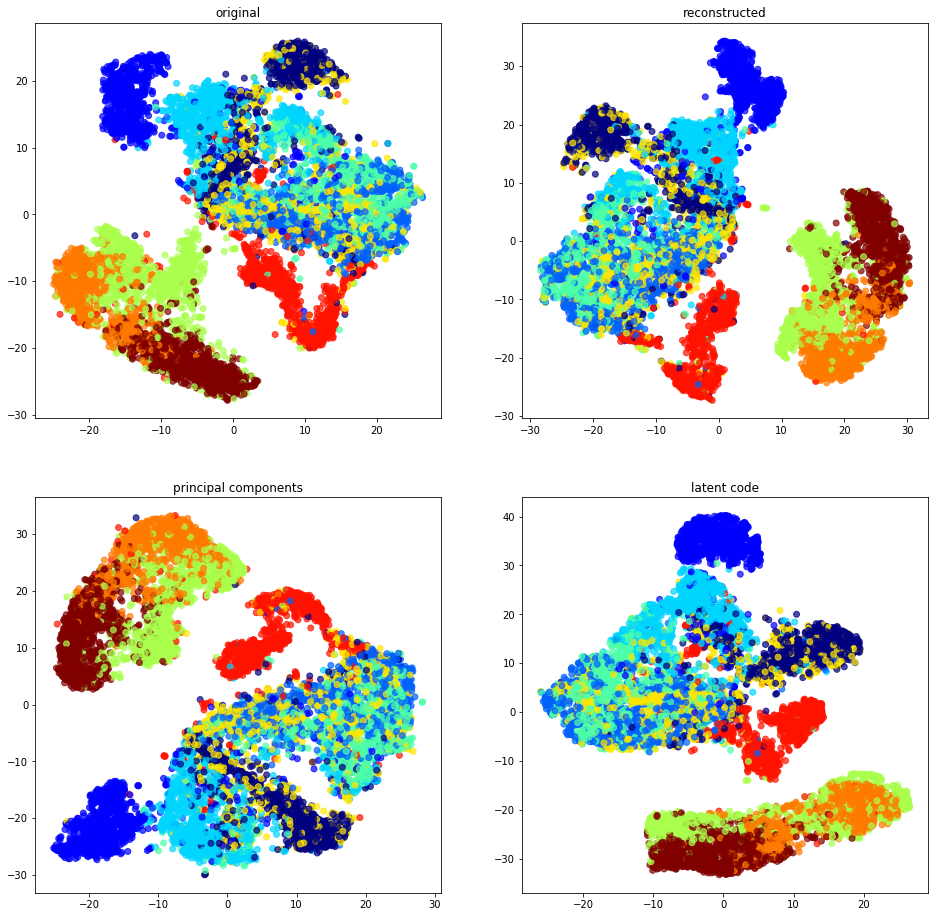

In [28]:
tsne = TSNE(n_components=2, n_jobs=4, perplexity=150)
x_te_tsne = tsne.fit_transform(test_features.reshape(-1, 784))

tsne = TSNE(n_components=2, n_jobs=4, perplexity=150)
reconstructed_tsne = tsne.fit_transform(reconstructed_scatter)

tsne = TSNE(n_components=2, n_jobs=4, perplexity=150)
pc_tsne = tsne.fit_transform(reduced_test_features)

tsne = TSNE(n_components=2, n_jobs=4, perplexity=150)
latent_code_tsne = tsne.fit_transform(z)

plt.figure(figsize=(16, 16))
plt.jet()

plt.subplot(221)
plt.scatter(x_te_tsne[:, 0], x_te_tsne[:, 1], c=test_labels, alpha=0.70)
plt.title('original')

plt.subplot(222)
plt.scatter(reconstructed_tsne[:, 0], reconstructed_tsne[:, 1], c=test_labels, alpha=0.70)
plt.title('reconstructed')

plt.subplot(223)
plt.scatter(pc_tsne[:, 0], pc_tsne[:, 1], c=test_labels, alpha=0.70)
plt.title('principal components')

plt.subplot(224)
plt.scatter(latent_code_tsne[:, 0], latent_code_tsne[:, 1], c=test_labels, alpha=0.70)
plt.title('latent code')

plt.savefig('tsne_fmnist.png', dpi=150)
plt.show()

## k-Means Clustering

Let's use k-Means Clustering algorithm on original data, reconstructed data, and latent code.

In [20]:
_, _, z_train = vae.encoder(tf.constant(training_features))
reconstructed_train = vae.decoder(z_train)

_, _, z_test = vae.encoder(tf.constant(noisy_test_features))
reconstructed_test = vae.decoder(z_test)

Performance evaluation of k-Means.

In [21]:
class Clustering():
    def __init__(self, num_clusters, n_init=10, epochs=300, cores=None):
        self.model = KMeans(init='k-means++', n_clusters=num_clusters, n_init=n_init, max_iter=epochs, n_jobs=cores)

    def train(self, training_data):
        self.model.fit(training_data)

    def predict(self, data):
        self.model.predict(data)
    
    def benchmark(self, name, data):
        start_time = time()
        predictions = self.model.predict(data)
        return ('%-9s\t%.2fs\t%.3f\t\t%.3f\t\t%.3f' % (name,
                                                       (time() - start_time),
                                                       metrics.davies_bouldin_score(data, predictions),
                                                       metrics.silhouette_score(data, predictions, metric='euclidean'),
                                                       metrics.calinski_harabaz_score(data, predictions)))

In [30]:
results = []

k_means = Clustering(num_clusters=10, epochs=500, cores=-1)
k_means.train(training_features.numpy().reshape(-1, 784))
result_original = k_means.benchmark(name='original', data=noisy_test_features.numpy().reshape(-1, 784))
results.append(result_original)

k_means = Clustering(num_clusters=10, epochs=500, cores=-1)
k_means.train(reconstructed_train.numpy().reshape(-1, 784))
result_vae = k_means.benchmark(name='reconstructed', data=reconstructed_test.numpy().reshape(-1, 784))
results.append(result_vae)

k_means = Clustering(num_clusters=10, epochs=500, cores=4)
k_means.train(reduced_training_features)
result_reduced = k_means.benchmark(name='reduced', data=reduced_test_features)
results.append(result_reduced)

k_means = Clustering(num_clusters=10, epochs=500, cores=-1)
k_means.train(z_train.numpy())
result_code = k_means.benchmark(name='latent_code', data=z_test.numpy())
results.append(result_code)

print(72 * '_')
print('init\t\ttime\tdb-index\tsilhouette\tch-score')

for result in results:
    print(result)

print(72 * '_')

/home/darth/tf2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/home/darth/tf2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/home/darth/tf2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


________________________________________________________________________
init		time	db-index	silhouette	ch-score
original 	0.05s	1.871		0.147		1195.735
reconstructed	0.04s	1.458		0.206		1892.949
reduced  	0.00s	1.127		0.292		3107.631
latent_code	0.00s	1.346		0.247		3533.938
________________________________________________________________________


/home/darth/tf2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=DeprecationWarning)


### Cluster Visualization

Cluster the original data.

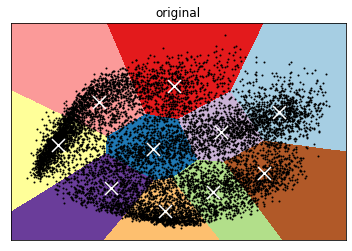

In [41]:
reduced_test_features = PCA(n_components=2).fit_transform(noisy_test_features.numpy().reshape(-1, 784))
k_means = KMeans(init='k-means++', n_clusters=10, n_init=10)
k_means.fit(reduced_test_features)

h = .02

x_min, x_max = reduced_test_features[:, 0].min() - 1, reduced_test_features[:, 0].max() + 1
y_min, y_max = reduced_test_features[:, 1].min() - 1, reduced_test_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_test_features[:, 0], reduced_test_features[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = k_means.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('original')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.savefig('original.png', dpi=150)
plt.show()

### Reconstructed Data

Cluster the reconstructed data.

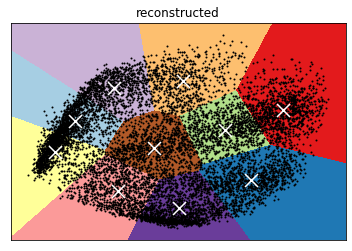

In [42]:
reduced_reconstructed_test = PCA(n_components=2).fit_transform(reconstructed_test.numpy().reshape(-1, 784))
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_reconstructed_test)

h = .02

x_min, x_max = reduced_reconstructed_test[:, 0].min() - 1, reduced_reconstructed_test[:, 0].max() + 1
y_min, y_max = reduced_reconstructed_test[:, 1].min() - 1, reduced_reconstructed_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_reconstructed_test[:, 0], reduced_reconstructed_test[:, 1], 'k.', markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('reconstructed')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.savefig('reconstructed.png', dpi=150)
plt.show()

### Principal Components

Cluster the principal components.

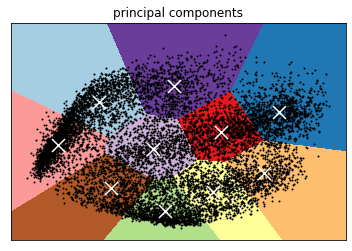

In [43]:
reduced_reduced_test_features = PCA(n_components=2).fit_transform(reduced_test_features)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_reduced_test_features)

h = .02

x_min, x_max = reduced_reduced_test_features[:, 0].min() - 1, reduced_reduced_test_features[:, 0].max() + 1
y_min, y_max = reduced_reduced_test_features[:, 1].min() - 1, reduced_reduced_test_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_reduced_test_features[:, 0], reduced_reduced_test_features[:, 1], 'k.', markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('principal components')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.savefig('principal_components.png', dpi=150)
plt.show()

### Latent Code

Cluster the latent code.

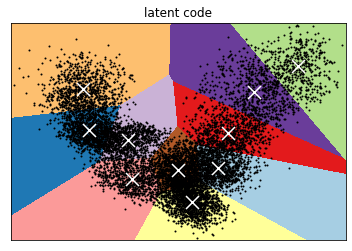

In [44]:
reduced_z = PCA(n_components=2).fit_transform(z)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_z)

h = .02

x_min, x_max = reduced_z[:, 0].min() - 1, reduced_z[:, 0].max() + 1
y_min, y_max = reduced_z[:, 1].min() - 1, reduced_z[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_z[:, 0], reduced_z[:, 1], 'k.', markersize=2)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('latent code')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.savefig('latent_code.png', dpi=150)
plt.show()